In [1]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp

import jaxley as jx
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse

from jaxley_mech.synapses import RibbonSynapse

### Ionotropic Synapse Reference

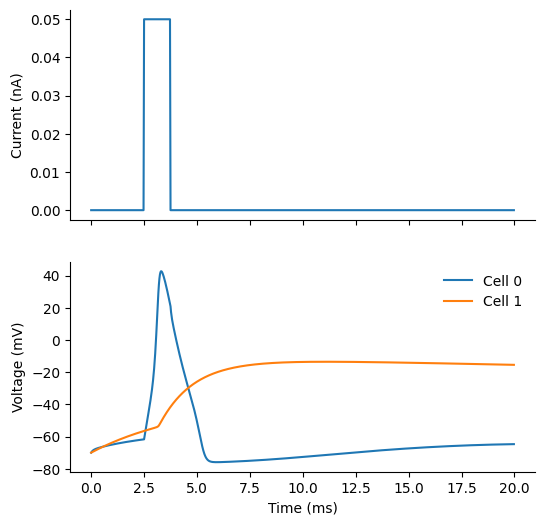

In [2]:
n_cells = 2
dt = 0.025
t_max = 20
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])

cell1 = network.cell([0])
cell2 = network.cell([1])
cell1.fully_connect(cell2, IonotropicSynapse())

# Insert mechanisms
cell1.insert(HH())
cell2.insert(Leak())
network.GlutamateSynapse.set("gS", 0.5)  # 1.5*np.random.randn(1)

network.delete_recordings()
network.cell(0).record()
network.cell(1).record()

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[100:150].set(0.05)

data_stimuli = None
data_stimuli = network.cell(0).data_stimulate(inp_current, data_stimuli=data_stimuli)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="fwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
_ = ax[1].plot(time, v[0, :-1], label="Cell 0")
_ = ax[1].plot(time, v[1, :-1], label="Cell 1")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

### Deterministic Ribbon Synapse Model

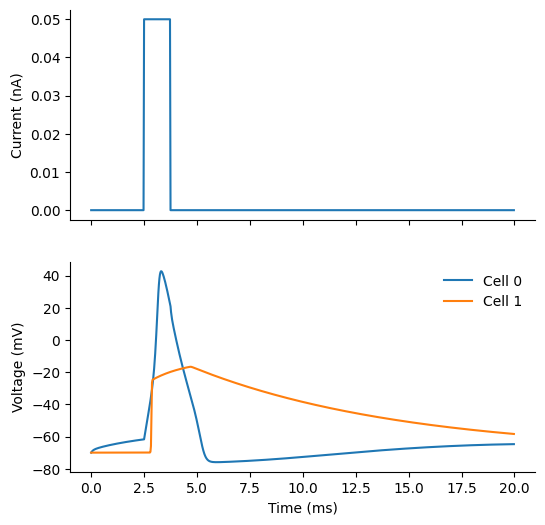

In [3]:
n_cells = 2
dt = 0.025
t_max = 20
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])

cell1 = network.cell([0])
cell2 = network.cell([1])
cell1.fully_connect(cell2, RibbonSynapse())
network.RibbonSynapse.set("gS", 0.5)
network.RibbonSynapse.set("tau", 0.5)

# Insert mechanisms
cell1.insert(HH())
cell2.insert(Leak())

network.delete_recordings()
network.cell(0).record()
network.cell(1).record()

time = jnp.arange(0, t_max, step=dt)
inp_current = jnp.zeros_like(time)
inp_current = inp_current.at[100:150].set(0.05)

data_stimuli = None
data_stimuli = network.cell(0).data_stimulate(inp_current, data_stimuli=data_stimuli)

v = jx.integrate(
    network, t_max=t_max, delta_t=dt, solver="fwd_euler", data_stimuli=data_stimuli
)

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

_ = ax[0].plot(time, inp_current)
_ = ax[1].plot(time, v[0, :-1], label="Cell 0")
_ = ax[1].plot(time, v[1, :-1], label="Cell 1")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

#### Changing the probability of vesicle movement from the ribbon to the dock ($p_r$)

(This model is a bit ill-behaved for probabilities too high)

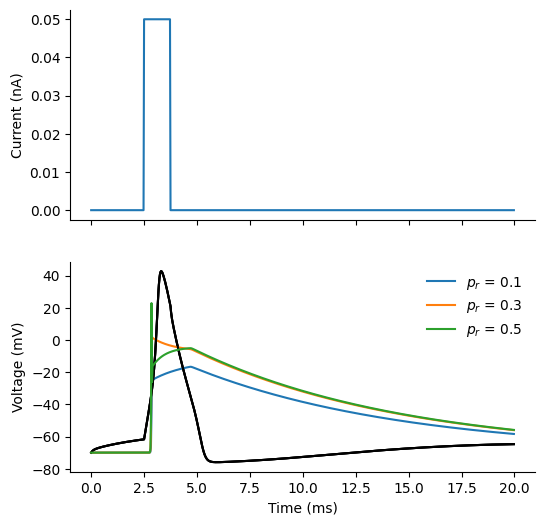

In [4]:
prs = [0.1, 0.3, 0.5]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

for p in prs:
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record()
    network.cell(1).record()

    network.RibbonSynapse.set("p_r", p)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="fwd_euler", data_stimuli=data_stimuli
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], label=f"$p_r$ = {p}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();

#### Changing the probability of vesicle movement from the cytoplasm to the ribbon (λ)

(In order for this parameter to have an effect, the initial number of vesicles at the ribbon should be reduced, or I guess the stimulus could be long enough to deplete the vesicles at the ribbon)

The trajectories shown indicate that the ribbon is depleted after the initial increase, as to be expected, after which a sufficient increase in movement from the cytoplasm to the ribbon can somewhat sustain the response.

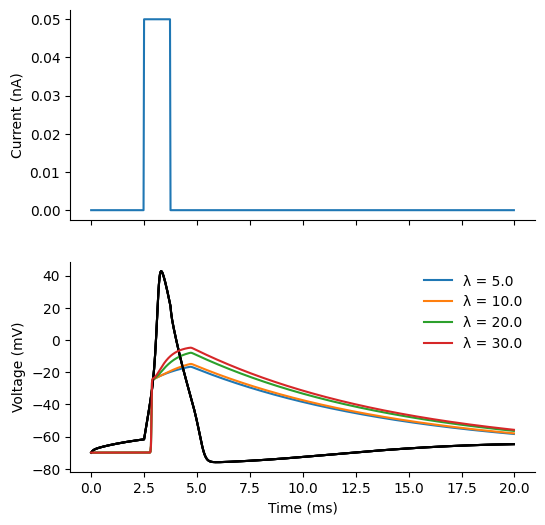

In [5]:
lams = [5.0, 10.0, 20.0, 30.0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
_ = ax[0].plot(time, inp_current)

for l in lams:
    _ = np.random.seed(0)

    network.delete_recordings()
    network.cell(0).record()
    network.cell(1).record()

    network.RibbonSynapse.set("ribboned", 1)
    network.set("p_r", 0.1)
    network.RibbonSynapse.set("lam", l)

    v = jx.integrate(
        network, t_max=t_max, delta_t=dt, solver="fwd_euler", data_stimuli=data_stimuli
    )

    _ = ax[1].plot(time, v[0, :-1], color="k")
    _ = ax[1].plot(time, v[1, :-1], label=f"λ = {l}")

ax[0].set_ylabel("Current (nA)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].set_xlabel("Time (ms)")
plt.legend(frameon=False)
sns.despine();